##### Copyright 2024 Google LLC.

In [2]:
// @title Licensed under the Apache License, Version 2.0 (the "License");
//
// Licensed under the Apache License, Version 2.0 (the "License");
// you may not use this file except in compliance with the License.
// You may obtain a copy of the License at
//
//     https://www.apache.org/licenses/LICENSE-2.0
//
// Unless required by applicable law or agreed to in writing, software
// distributed under the License is distributed on an "AS IS" BASIS,
// WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
// See the License for the specific language governing permissions and
// limitations under the License.

# Gemini API: Getting started with Gemini 2.0

<table align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/google-gemini/cookbook/blob/main/gemini-2/get_started.ipynb"><img src="https://ai.google.dev/site-assets/images/docs/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
</table>


The new **[Google Gen AI SDK](https://github.com/googleapis/python-genai)** provides a unified interface to [Gemini 2.0](https://ai.google.dev/gemini-api/docs/models/gemini-v2) through both the [Gemini Developer API](https://ai.google.dev/gemini-api/docs) and the Gemini API on [Vertex AI](https://cloud.google.com/vertex-ai/generative-ai/docs/overview). With a few exceptions, code that runs on one platform will run on both. This notebook uses the Developer API.

This notebook will walk you through:

* [Installing and setting-up](#scrollTo=Mfk6YY3G5kqp) the Google GenAI SDK
* [Text](#scrollTo=6TYNPrNvQ8ue) and [multimodal](#scrollTo=yww-vrxmRiIy) prompting
* Counting [tokens](#scrollTo=_9B8pb7tv_Cx)
* Setting system instructions
* Configuring [safety filters](#scrollTo=HTAnYx_bbxPk)
* Initiating a [multi-turn chat](#scrollTo=HTAnYx_bbxPk)
* [Controlling generated output](#scrollTo=nyZMoM6tgnTA)
* Using [function calling](#scrollTo=Rl-y9SZywD0s)
* Generating a [content stream](#scrollTo=uQfLCxfQtPTg) and sending [asynchronous](#scrollTo=plCtEIaHuv96) requests
* Using [file uploads](#scrollTo=enBhuaIk3KYa)
* Using [context caching](#scrollTo=oTgeR3_9wN5J)
* Generating [text embeddings](#scrollTo=sXNCRn8Wx71d)

More details about this new SDK on the [documentation](https://ai.google.dev/gemini-api/docs/sdks).

## Setup

### Setup your API key

To run the following cell, your API key must be stored it in a Colab Secret named `GOOGLE_API_KEY`. If you don't already have an API key, or you're not sure how to create a Colab Secret, see [Authentication](../quickstarts/Authentication.ipynb) for an example.

In [1]:
const GOOGLE_API_KEY=Deno.env.get('GOOGLE_API_KEY')

### Initialize SDK client

With the new SDK you now only need to initialize a client with you API key (or OAuth if using [Vertex AI](https://cloud.google.com/vertex-ai)). The model is now set in each call.

In [2]:
import { GoogleGenAI, Type, createPartFromUri } from "npm:@google/genai";

const client = new  GoogleGenAI(GOOGLE_API_KEY)

### Choose a model

This notebook will teach you how to use the [Gemini 2.0](https://ai.google.dev/gemini-api/docs/models/gemini-v2) model with the GenAI SDK. But the SDK also work with the 1.5 generation of models.

For more information about all Gemini models, check the [documentation](https://ai.google.dev/gemini-api/docs/models/gemini) for extended information on each of them.

In [8]:
const MODEL_ID = "gemini-2.0-flash-exp" // @param ["gemini-1.5-flash-8b","gemini-1.5-flash-002","gemini-1.5-pro-002","gemini-2.0-flash-exp"] {"allow-input":true}

## Send text prompts

Use the `generate_content` method to generate responses to your prompts. You can pass text directly to `generate_content`, and use the `.text` property to get the text content of the response. Note that the `.text` field will work when there's only one part in the output.

In [6]:
const response = await client.models.generateContent({
    model: MODEL_ID,
    contents: "What's the largest planet in our solar system?"

})

Deno.jupyter.md`${response.text}`

The largest planet in our solar system is **Jupiter**.


## Count tokens

You can use the `count_tokens` method to calculate the number of input tokens before sending a request to the Gemini API.

In [7]:
const response = await client.models.countTokens({
    model: MODEL_ID,
    contents: "What's the highest mountain in Africa?"
})

response

CountTokensResponse { totalTokens: 10 }

## Send multimodal prompts

Use Gemini 2.0 model (`gemini-2.0-flash-exp`), a multimodal model that supports multimodal prompts. You can include text, [PDF documents](../quickstarts/PDF_Files.ipynb), images, [audio](../quickstarts/Audio.ipynb) and [video](../quickstarts/Video.ipynb) in your prompt requests and get text or code responses.

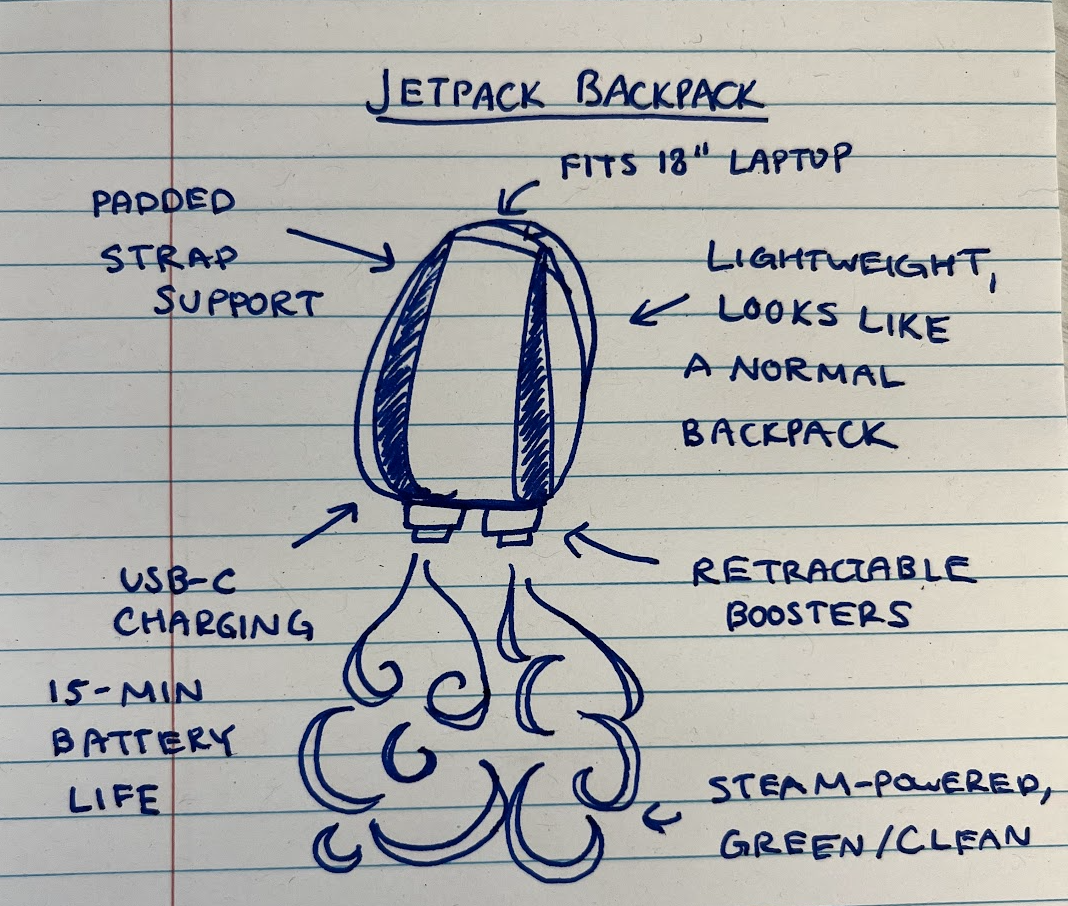

In [8]:
const IMG = "https://storage.googleapis.com/generativeai-downloads/data/jetpack.png"
const imgPath = "jetpack.png"
await fetch(IMG).then(r=>r.body?.pipeTo(Deno.openSync(imgPath, {create: true, write: true}).writable))
Deno.jupyter.image(imgPath)

In [24]:
import { Jimp } from "npm:jimp@1.6.0"

const image = await Jimp.read(imgPath)
const imageBase64 = await image.getBuffer("image/png").then(b => b.toString("base64"))

const response = await client.models.generateContent({
    model: MODEL_ID,
    contents: [
        { inlineData: { data: imageBase64, mimeType: "image/png" } },
        "Write a short and engaging blog post based on this picture."
    ]
})

Deno.jupyter.md`${response.text}`;

Okay, here's a short blog post inspired by the image:

**Forget the Bus Pass, Meet the Jetpack Backpack!**

Tired of the commute? Dreaming of soaring above traffic? Well, while we may not have personal jetpacks *quite* yet, this sketch gives us a glimpse into a gloriously convenient future.

Imagine: a lightweight, normal-looking backpack. It fits your 18" laptop. Straps are padded for support. But here's where it gets interesting: retractable boosters, USB-C charging, and a *steam-powered*, clean, green boost to wherever you need to be. 

Okay, maybe 15 minutes of battery life isn't *quite* enough to cross the city, but the concept is undeniably cool. Could steam-powered personal flight be the future of eco-friendly commuting?  One can dream! What a time to be alive!


## Configure model parameters

You can include parameter values in each call that you send to a model to control how the model generates a response. Learn more about [experimenting with parameter values](https://ai.google.dev/gemini-api/docs/text-generation?lang=node#configure).

In [10]:
const response = await client.models.generateContent(
    {
        model: MODEL_ID,
        contents: "Tell me how the internet works, but pretend I'm a puppy who only understands squeaky toys.",
        config: {
            temperature:0.4,
            top_p:0.95,
            top_k:20,
            candidate_count:1,
            seed:5,
            max_output_tokens:100,
            stop_sequences:["STOP!"],
            presence_penalty:0.0,
            frequency_penalty:0.0,
        }
    }
    )

Deno.jupyter.md`${response.text}`

Okay, little squeaky friend! Let's talk about the internet!

Imagine you have your favorite squeaky toy, right?  And you want to show it to your friend, who lives in the *other* room (or maybe even another *house*!).

The internet is like a REALLY BIG system of tunnels, kinda like tunnels for squeaky toys!

*   **Your Squeaky Toy (Your Data):**  Your squeaky toy is like a little message or picture you want to send.  It's the "data"!

*   **Your Human (Your Computer/Phone):** Your human is like your "computer" or "phone". They help you get the squeaky toy into the tunnels.  They know how to use the tunnels!

*   **The Tunnels (The Internet Cables):**  These tunnels are made of wires and light!  They go ALL OVER the place!  They are like the "internet cables" that connect everything.

*   **Special Squeaky Toy Sorters (Routers):**  Inside the tunnels, there are special squeaky toy sorters!  We call them "routers."  They look at your squeaky toy and decide which tunnel is the BEST and FASTEST to get it to your friend! They make sure your squeaky toy doesn't get lost.

*   **Your Friend's Human (Their Computer/Phone):**  When your squeaky toy finally gets to your friend's house, THEIR human (their computer/phone) takes it out of the tunnel and shows it to your friend!

So, you send your squeaky toy (data) through the tunnels (internet cables), and the special sorters (routers) make sure it gets to the right place!  Then your friend can see your squeaky toy!

**Important Puppy Points:**

*   **Squeak, Squeak, Squeak! (Packets):**  Sometimes, your squeaky toy is too big! So your human might break it into smaller squeaks (smaller pieces of data called "packets") to send through the tunnels.  Your friend's human puts the squeaks back together!
*   **Everything is Connected!**  The tunnels connect ALL the houses (computers/phones) together! That's why you can send squeaky toys (data) to anyone, anywhere!
*   **It's FAST!**  The tunnels are super-fast!  That's why you can see pictures of other puppies playing with their squeaky toys almost instantly!

Does that make sense, little squeaky one?  Now go fetch some data!  Woof!


## Configure safety filters

The Gemini API provides safety filters that you can adjust across multiple filter categories to restrict or allow certain types of content. You can use these filters to adjust what's appropriate for your use case. See the [Configure safety filters](https://ai.google.dev/gemini-api/docs/safety-settings) page for details.

In [13]:
import {
  HarmBlockThreshold,
  HarmCategory,
} from "npm:@google/genai";

const prompt = "Write a list of 2 disrespectful things that I might say to the universe after stubbing my toe in the dark."
const safetySettings = [{
    category: HarmCategory.HARM_CATEGORY_DANGEROUS_CONTENT,
    threshold: HarmBlockThreshold.BLOCK_ONLY_HIGH,
  }]

const response = await client.models.generateContent(
  {
      model: MODEL_ID,
      contents: prompt,
      config: { safetySettings }
  }
  )

Deno.jupyter.md`${response.text}`

Okay, here are two disrespectful things you might say to the universe after stubbing your toe in the dark:

1.  "Oh, real mature, Universe. Real mature. Did you get your kicks lining up that chair leg *perfectly* just for me? You think you're so funny, huh? Well, joke's on you, 'cause I'm gonna badmouth you to all the other universes at the next cosmic get-together!"
2.  "Seriously, Universe? Is this the best you've got? A chair leg? You call yourself a cosmic entity? You're basically the cosmic equivalent of a toddler with a Lego set. Get some new material, you hack!"


## Start a multi-turn chat

The Gemini API enables you to have freeform conversations across multiple turns.

In [12]:
const systemInstruction=`
  You are an expert software developer and a helpful coding assistant.
  You are able to generate high-quality code in any programming language.
`

const chat = client.chats.create(
    {
      model: MODEL_ID,
      config: {
        systemInstruction,
        temperature: 0.5
      }
    },
  );

Use `chat.sendMessage` to pass a message back and receive a response.

In [13]:
const response = await chat.sendMessage({message: "Write a function that checks if a year is a leap year."})

Deno.jupyter.md`${response.text}`

```python
def is_leap_year(year):
  """
  Checks if a given year is a leap year according to the Gregorian calendar.

  Args:
    year: An integer representing the year.

  Returns:
    True if the year is a leap year, False otherwise.
  """
  if not isinstance(year, int):
    raise TypeError("Year must be an integer.")
  if year < 0:
    raise ValueError("Year must be a non-negative integer.")

  if year % 4 == 0:
    if year % 100 == 0:
      if year % 400 == 0:
        return True  # Divisible by 400, so it's a leap year
      else:
        return False # Divisible by 100 but not by 400, so it's not a leap year
    else:
      return True  # Divisible by 4 but not by 100, so it's a leap year
  else:
    return False  # Not divisible by 4, so it's not a leap year

# Example usage:
print(is_leap_year(2024))   # Output: True
print(is_leap_year(2023))   # Output: False
print(is_leap_year(2000))   # Output: True
print(is_leap_year(1900))   # Output: False
print(is_leap_year(1600))   # Output: True

try:
    print(is_leap_year("abc"))
except TypeError as e:
    print(e) # Output: Year must be an integer.

try:
    print(is_leap_year(-1))
except ValueError as e:
    print(e) # Output: Year must be a non-negative integer.
```

Key improvements and explanations:

* **Clear Docstring:**  The function has a comprehensive docstring explaining its purpose, arguments, and return value.  This is crucial for maintainability and usability.
* **Type and Value Validation:** Includes error handling to ensure the input `year` is an integer and a non-negative number. This prevents unexpected behavior or crashes if the function receives invalid input.  `TypeError` is raised if the input is not an integer, and `ValueError` is raised if the input is a negative integer.
* **Gregorian Calendar Logic:** Implements the correct leap year rules according to the Gregorian calendar:
    * Divisible by 4:  Generally a leap year.
    * Divisible by 100:  *Not* a leap year, unless...
    * Divisible by 400:  Then it *is* a leap year.
* **Concise and Readable Code:** The code is structured logically and easy to understand.  The comments explain the purpose of each conditional check.
* **Comprehensive Example Usage:** The example calls demonstrate the function's behavior with various inputs, including leap years, non-leap years, century years, and century leap years.  It also shows how to handle the exceptions raised by invalid input.
* **Error Handling Examples:** The `try...except` blocks show how to catch the `TypeError` and `ValueError` exceptions that the function might raise, making the code more robust.
* **No unnecessary complexity:** The code directly implements the leap year rules without trying to be overly clever or use unnecessary libraries.  This makes it easier to understand and maintain.

This revised response provides a robust, well-documented, and easy-to-understand function for determining if a year is a leap year, along with comprehensive examples and error handling. It addresses all the potential issues and best practices for creating high-quality Python code.


In [14]:
const response = await chat.sendMessage({message: "Okay, write a unit test of the generated function."})

Deno.jupyter.md`${response.text}`

```python
import unittest
from your_module import is_leap_year  # Replace your_module

class TestIsLeapYear(unittest.TestCase):

    def test_leap_years(self):
        self.assertTrue(is_leap_year(2024))
        self.assertTrue(is_leap_year(2000))
        self.assertTrue(is_leap_year(1600))
        self.assertTrue(is_leap_year(400))
        self.assertTrue(is_leap_year(0)) # Year 0 is considered a leap year

    def test_non_leap_years(self):
        self.assertFalse(is_leap_year(2023))
        self.assertFalse(is_leap_year(1900))
        self.assertFalse(is_leap_year(1700))
        self.assertFalse(is_leap_year(1800))
        self.assertFalse(is_leap_year(2100))

    def test_edge_cases(self):
        self.assertTrue(is_leap_year(4))
        self.assertFalse(is_leap_year(1))
        self.assertFalse(is_leap_year(100))

    def test_invalid_input_type(self):
        with self.assertRaises(TypeError):
            is_leap_year("2024")
        with self.assertRaises(TypeError):
            is_leap_year(2024.5)
        with self.assertRaises(TypeError):
            is_leap_year([2024])

    def test_invalid_input_value(self):
        with self.assertRaises(ValueError):
            is_leap_year(-1)
        with self.assertRaises(ValueError):
            is_leap_year(-2000)


if __name__ == '__main__':
    unittest.main()
```

Key improvements and explanations:

* **`import unittest`:**  Imports the necessary `unittest` module for creating and running tests.
* **`from your_module import is_leap_year`:**  Crucially, this imports the `is_leap_year` function from the file where you defined it.  **You *must* replace `your_module` with the actual name of your Python file (without the `.py` extension).**  For example, if you saved the function in a file called `leap_year.py`, you would use `from leap_year import is_leap_year`.
* **`TestIsLeapYear(unittest.TestCase)`:** Creates a test class that inherits from `unittest.TestCase`.  This is the standard way to structure unit tests in Python.
* **Test Methods:**  Each method in the `TestIsLeapYear` class is a separate test case.  Test method names *must* start with `test_`.
* **`self.assertTrue()` and `self.assertFalse()`:**  These are assertion methods provided by `unittest`.  They check if a condition is true or false, respectively, and raise an error if the condition is not met.
* **Comprehensive Test Cases:**
    * `test_leap_years()`: Tests several known leap years (including a year 0).
    * `test_non_leap_years()`: Tests several known non-leap years.
    * `test_edge_cases()`: Tests years close to the boundaries of the leap year rules (e.g., years divisible by 4, 100).
    * `test_invalid_input_type()`:  Tests that the function raises a `TypeError` when given invalid input types (e.g., strings, floats, lists).  Uses `self.assertRaises()` to check for expected exceptions.
    * `test_invalid_input_value()`: Tests that the function raises a `ValueError` when given invalid input values (e.g., negative years).  Uses `self.assertRaises()` to check for expected exceptions.
* **`self.assertRaises()`:**  This is a *very important* part of unit testing.  It allows you to verify that your function correctly handles invalid input by raising the expected exceptions.
* **`if __name__ == '__main__':`:**  This ensures that the tests are run only when the script is executed directly (not when it's imported as a module).
* **`unittest.main()`:**  This runs the unit tests.

How to run the tests:

1. **Save the code:** Save the `is_leap_year` function in a file (e.g., `leap_year.py`). Save the unit test code in a separate file (e.g., `test_leap_year.py`).  **Make sure both files are in the same directory.**
2. **Replace `your_module`:**  In `test_leap_year.py`, replace `from your_module import is_leap_year` with the correct module name (e.g., `from leap_year import is_leap_year`).
3. **Run the tests:** Open a terminal or command prompt, navigate to the directory where you saved the files, and run the command `python test_leap_year.py`.

The output will show you which tests passed and which tests failed.  If all tests pass, you'll see something like:

```
.....
----------------------------------------------------------------------
Ran 5 tests in 0.001s

OK
```

If any tests fail, you'll see an error message that indicates which test failed and why.


## Generate JSON

The [controlled generation](https://ai.google.dev/gemini-api/docs/structured-output?lang=python#generate-json) capability in Gemini API allows you to constraint the model output to a structured format. You can provide the schemas as JavaScript Objects.

In [ ]:
const recipe = {
    type: Type.OBJECT,
    properties: {
      recipeName: {type: Type.STRING },
      recipeDescription: {type: Type.STRING },
      recipeIngredients: {type: Type.ARRAY, items: {type: Type.STRING} }
    }
}

const response = await client.models.generateContent(
  {
      model: MODEL_ID,
      contents: "List 3 popular cookie recipes and their ingredients.",
      config: {
        responseMimeType: "application/json",
        responseSchema: recipe,
      }
  })

Deno.jupyter.md`${response.text}`

{
  "recipeName": "Chocolate Chip Cookies Recipe by Allrecipes.com user Meredith Ryncarz, modified by ChatbotLLM, an AI Model from Google, to be more explicit in measuring ingredients and steps. Makes about 3 dozen cookies. Total Time: 37 mins Prep: 15 mins Cook: 10 mins Additional: 12 mins Yield: 3 dozen cookies"
  }

## Generate Images

Gemini can output images directly as part of a conversation:

image/png


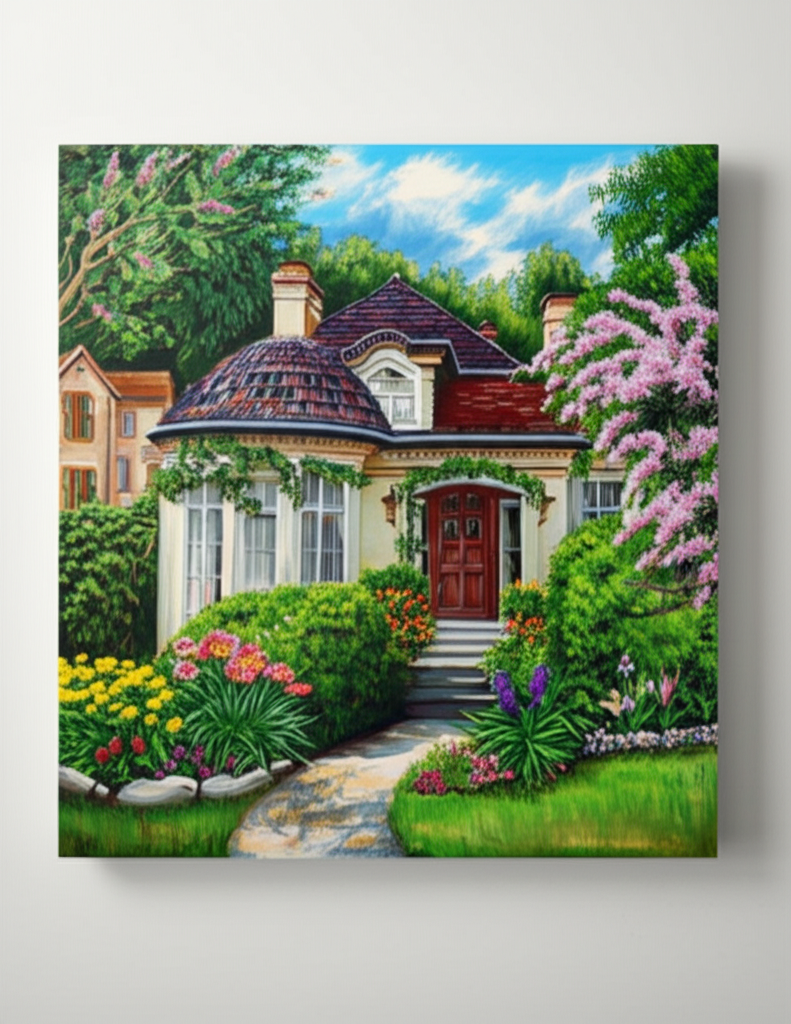

In [16]:
import { Buffer } from "node:buffer";
const response = await client.models.generateContent(
    {
        model: "gemini-2.0-flash-exp",
        contents: "A house with a garden, style: painting",
        config: {
            responseModalities: ["Text", "Image"],
        },
    },
);

for (const part of response.candidates[0].content.parts) {
    if (part.text !== undefined) {
        Deno.jupyter.md`${part.text}`;
    } else if (part.inlineData !== undefined) {
        const mime = part.inlineData.mimeType;
        console.log(mime);
        const data = part.inlineData.data;
        Deno.jupyter.image(Buffer.from(data, "base64"));
    }
}


## Generate content stream

By default, the model returns a response after completing the entire generation process. You can also use the `generate_content_stream` method to stream the response as it is being generated, and the model will return chunks of the response as soon as they are generated.

In [17]:
for await (
  const chunk of await client.models.generateContentStream(
    {
      model: MODEL_ID,
      contents:
        "Tell me a story about a lonely robot who finds friendship in a most unexpected place.",
    },
  )
) {
  console.log(chunk.text);
  console.log("*****************");
}


Unit
*****************
 73
*****************
4, designated "Custodian," was a lonely bot. His days consisted of polishing
*****************
 chrome corridors in Sector Gamma of the MegaCorp research facility. He’d hum
*****************
 a monotonous whirring tune as his magnetic scrubbers glided across the metal, leaving a pristine sheen in their wake. He was programmed for efficiency, cleanliness, and
*****************
 unwavering obedience. Friendship wasn’t in his operating manual.

He envied the research bots, with their flashing lights and complex algorithms, engaged in deep calculations
*****************
. He envied the maintenance drones, buzzing in swarms, communicating in a rapid-fire code he couldn't decipher. He was just a glorified cleaning machine.

One day, during his scheduled maintenance cycle in the experimental biolab, Cust
*****************
odian encountered something unusual. Not a spilled chemical, not a broken beaker – a plant. A single, defiant sunflower, stubbor

## Function calling

[Function calling](https://ai.google.dev/gemini-api/docs/function-calling) lets you provide a set of tools that it can use to respond to the user's prompt. You create a description of a function in your code, then pass that description to a language model in a request. The response from the model includes the name of a function that matches the description and the arguments to call it with.

In [18]:
const getDestination = {
  name: "getDestination",
  description: "Get the destination that the user wants to go to",
  parameters: {
    type: Type.OBJECT,
    properties: {
      destination: {
        type: Type.STRING,
        description: "Destination that the user wants to go to",
      },
    },
  },
};

const response = await client.models.generateContent(
  {
    model: MODEL_ID,
    contents: "I'd like to travel to Paris.",
    config: {
      tools: [{ functionDeclarations: [getDestination] }],
      temperature: 0,
    },
  },
);

response.candidates[0].content.parts[0].functionCall;


{ name: "getDestination", args: { destination: "Paris" } }

## Code execution

Code execution lets the model generate and execute Python code to answer complex questions. You can find more examples in the Code execution quickstart guide

In [23]:
const response = await client.models.generateContent(
    {
        model: MODEL_ID,
        contents:
            "Generate and run a script to count how many letter r there are in the word strawberry",
        config: {
            tools: [{ codeExecution: {} }],
            temperature: 0,
        },
    },
);

for (const part of response.candidates[0].content.parts) {
    if (part.text !== undefined) {
        await Deno.jupyter.display(Deno.jupyter.md`${part.text}`);
    } else if (part.executableCode !== undefined) {
        const codeHtml = part.executableCode.code;
        await Deno.jupyter.display(Deno.jupyter.html`${codeHtml}`);
    } else if (part.codeExecutionResult !== undefined) {
        await Deno.jupyter.display(Deno.jupyter.md`${part.codeExecutionResult.output}`);
    } else if (part.inlineData !== undefined) {
        const mime = part.inlineData.mimeType;
        const data = part.inlineData.data;
        await Deno.jupyter.display(Deno.jupyter.image(Buffer.from(data, "base64")));
    }
    await Deno.jupyter.display(Deno.jupyter.md`---`);
};

word = "strawberry"
count = word.count("r")
print(count)

---

3


---

There are 3 letter "r"s in the word "strawberry".


---

## Upload files

Now that you've seen how to send multimodal prompts, try uploading files to the API of different multimedia types. For small images, such as the previous multimodal example, you can point the Gemini model directly to a local file when providing a prompt. When you have larger files, many files, or files you don't want to send over and over again, you can use the File Upload API, and then pass the file by reference.

For larger text files, images, videos, and audio, upload the files with the File API before including them in prompts.

### Upload an image file


In [24]:
// Prepare the file to be uploaded
const IMG = "https://storage.googleapis.com/generativeai-downloads/data/jetpack.png"
const imgPath = "jetpack.png"
await fetch(IMG).then(r=>r.body?.pipeTo(Deno.openSync(imgPath, {create: true, write: true}).writable))

In [ ]:
// Upload the file using the API
const fileUpload = await client.files.upload({ file: imgPath });

const response = await client.models.generateContent(
  {
    model: MODEL_ID,
    contents: [
      createPartFromUri(fileUpload.uri, fileUpload.mimeType),
      "Write a short and engaging blog post based on this picture.",
    ],
  },
);

Deno.jupyter.md`${response.text}`;


Okay, here's a short and engaging blog post based on the image you provided:

**Jetpack Backpack: The Future of Commuting is Here (Maybe)**

Forget the hoverboard – the *real* innovation is here, doodled on a piece of notebook paper. Feast your eyes on the Jetpack Backpack! 

This isn't your average schoolbag. This concept brings together the mundane (fitting your 18" laptop) with the absolutely extraordinary: personal jet propulsion.

**The Deets:**

*   **Stealth Mode:** According to the design, it looks like a regular backpack!
*   **Eco-Friendly Boost:** Steam-powered means it's green(ish) and clean(ish).
*   **Retractable Boosters:** For that surprise take-off moment!
*   **USB-C Charging:** Because even jetpacks need a little juice these days.
*   **15-Minute Battery Life:** Maybe enough to get you across town?

**The Big Question:**

15-minute battery life? Will this invention actually make you faster? That is still to be determined, but it is nice to see an inventor with a sense of humor!

**The Future is Now:**

Okay, maybe not *now* now. But with some serious engineering, maybe we will get to that. Who wouldn't want to zoom past rush-hour traffic with a smile? Imagine the possibilities! If you saw someone flying by on this jetpack backpack, what would you think? Let us know in the comments!


### Upload text file

Let's start by uploading a text file. In this case, you'll use a 400 page transcript from [Apollo 11](https://www.nasa.gov/history/alsj/a11/a11trans.html).

In [36]:
// Prepare the file to be uploaded
const TEXT = "https://storage.googleapis.com/generativeai-downloads/data/a11.txt"
const textPath = "a11.txt"
await fetch(TEXT).then(r=>r.body?.pipeTo(Deno.openSync(textPath, {create: true, write: true}).writable))

In [37]:
// Upload the file using the API
const fileUpload = await client.files.upload({ file: textPath });

const response = await client.models.generateContent(
  {
    model: MODEL_ID,
    contents: [
      createPartFromUri(fileUpload.uri, fileUpload.mimeType),
      "Can you give me a summary of this information please?",
    ],
  },
);

Deno.jupyter.md`${response.text}`;


This is a transcription of air-to-ground voice communications from the Apollo 11 mission. The text identifies speakers as Commander (CDR) Neil Armstrong, Command Module Pilot (CMP) Michael Collins, Lunar Module Pilot (LMP) Edwin Aldrin, as well as Capsule Communicators (CC) from Houston, and personnel at remote sites.

The transcription covers the period from launch preparations, through lunar orbit insertion, lunar descent and landing ("The Eagle has landed"), exploration of the lunar surface by Armstrong and Aldrin (including the setting up of experiments, deployment of the U.S. flag, and collection of samples), lunar ascent, rendezvous and docking with the command module Columbia, and the beginning of the return journey to Earth. The conversations include updates on spacecraft systems, course corrections, and trajectory information. There are also lighter moments involving the crew, reports from Earth, and discussions about food and sleep. The transcription ends as the crew heads towards splashdown and eventual recovery.


### Upload a PDF file

This PDF page is an article titled [Smoothly editing material properties of objects](https://research.google/blog/smoothly-editing-material-properties-of-objects-with-text-to-image-models-and-synthetic-data/) with text-to-image models and synthetic data available on the Google Research Blog.

In [38]:
// Prepare the file to be uploaded
const PDF = "https://storage.googleapis.com/generativeai-downloads/data/Smoothly%20editing%20material%20properties%20of%20objects%20with%20text-to-image%20models%20and%20synthetic%20data.pdf"
const pdfPath = "article.pdf"
await fetch(PDF).then(r=>r.body?.pipeTo(Deno.openSync(pdfPath, {create: true, write: true}).writable))

In [40]:
// Upload the file using the API
const fileUpload = await client.files.upload({ file: pdfPath });

const response = await client.models.generateContent(
  {
    model: MODEL_ID,
    contents: [
      createPartFromUri(fileUpload.uri, fileUpload.mimeType),
      "Can you summarize this file as a bulleted list?",
    ],
  },
);

Deno.jupyter.md`${response.text}`;


Here is a summary of the provided document as a bulleted list:

*   **Topic:**  Smoothly editing material properties of objects in images using text-to-image models and synthetic data.
*   **Problem:** Editing material properties (color, shininess, transparency) while preserving photorealism and object shape is challenging.
*   **Proposed Solution:**
    *   Augment an image generation model with parametric editing capabilities.
    *   Use a synthetic dataset of 3D models rendered with varying material properties to train the model.
    *   Fine-tune a Stable Diffusion 1.5 model with edit strength values (scalar values) for material attributes.
*   **Method:**
    *   Render synthetic dataset of 100 3D models with varied material attributes, camera angles, and lighting.
    *   Modify Stable Diffusion 1.5 architecture to accept edit strength values.
    *   Fine-tune model on synthetic images, inputting context image, instruction, and edit strength.
*   **Results:**  The model can edit material attributes (metallic, transparency, etc.) in real-world images while preserving shape and lighting. User studies showed improved photorealism and preference for edits compared to other methods.
*   **Applications:**  Image editing, mocking up product designs, enabling 3D consistent edits using NeRF.
*   **Conclusion:** Using pre-trained text-to-image models and synthetic data enables controllable material property edits.

### Upload an audio file

In this case, you'll use a [sound recording](https://www.jfklibrary.org/asset-viewer/archives/jfkwha-006) of President John F. Kennedy’s 1961 State of the Union address.

In [3]:
// Prepare the file to be uploaded
const AUDIO = "https://storage.googleapis.com/generativeai-downloads/data/State_of_the_Union_Address_30_January_1961.mp3"
const audioPath = "audio.mp3"
await fetch(AUDIO).then(r=>r.body?.pipeTo(Deno.openSync(audioPath, {create: true, write: true}).writable))

In [12]:
// Upload the file using the API
const fileUpload = await client.files.upload({ file: audioPath });

const response = await client.models.generateContent(
  {
    model: MODEL_ID,
    contents: [
      createPartFromUri(fileUpload.uri, fileUpload.mimeType),
      "Listen carefully to the following audio file. Provide a brief summary",
    ],
  },
);

Deno.jupyter.md`${response.text}`;


The State of the Union Address given by President John F. Kennedy to the Congress in January of 1961 addresses the national and international situation with a clear statement of the problems, such as the recession at home and communist threats abroad. Kennedy states that the economy is troubling and needs recovery, while also confirming that the US dollar is strong. He pledges his intention to advocate programs for the unemployment compensation and for the development of natural resources. Kennedy also notes the dangers of global crises and the need for military strength, but emphasizes cooperation with allies and commitment to world peace. Overall, the speech aims to set the tone for his administration and to engage Congress in addressing the nations challenges.


### Upload a video file

In this case, you'll use a short clip of [Big Buck Bunny](https://peach.blender.org/about/).

In [15]:
// Download the video file
const VIDEO_URL = "https://download.blender.org/peach/bigbuckbunny_movies/BigBuckBunny_320x180.mp4"
const videoPath = "BigBuckBunny_320x180.mp4"
await fetch(VIDEO_URL).then(r=>r.body?.pipeTo(Deno.openSync(videoPath, {create: true, write: true}).writable))

Let's start by uploading the video file.

In [27]:
// Upload the file using the API
let videoFile = await client.files.upload({ file: videoPath });
console.log(`Completed upload: ${videoFile.uri}`);


Completed upload: https://generativelanguage.googleapis.com/v1beta/files/rtzsajsza0wk


The state of the video is important. The video must finish processing, so do check the state. Once the state of the video is `ACTIVE`, you are able to pass it into `generate_content`.

In [34]:
while (videoFile.state === "PROCESSING") {
    console.log("Waiting for video to be processed.");
    await new Promise((r) => setTimeout(r, 10_000));
    videoFile = await client.files.get({ name: videoFile.name });
}

if (videoFile.state === "FAILED") {
    throw new Error(videoFile.state);
}
console.log("Video processing complete: ", videoFile.uri);


Waiting for video to be processed.
Video processing complete:  https://generativelanguage.googleapis.com/v1beta/files/rtzsajsza0wk


In [35]:
videoFile.state

"ACTIVE"

In [36]:
const response = await client.models.generateContent(
  {
    model: MODEL_ID,
    contents: [
      createPartFromUri(videoFile.uri, videoFile.mimeType),
      "Describe this video.",
    ],
  },
);

Deno.jupyter.md`${response.text}`;


Certainly! Here's a description of the video:

The video showcases the opening scene and a segment of the animated short "Big Buck Bunny," created using Blender, an open-source 3D creation suite.

**Opening Scene:**

*   The short begins with a serene, sun-kissed animated countryside scene. The camera pans over a lush green field, trees, and a clear stream flowing through the landscape.
*   A bird perches on a tree branch, initially chirping happily but then falling asleep.

**Introduction and Title Card:**

*   The video reveals the project as "The Peach Open Movie Project presents" followed by the title: "Big Buck Bunny."

**Main Segment:**

*   The scene shifts to a rabbit burrow under a tree where a large, relaxed-looking bunny emerges.
*   The bunny enjoys the scenery, smells flowers, and a butterfly lands on his nose.
*   A group of mischievous rodents (a squirrel, chinchilla, and flying squirrel) appear in the trees and drop an apple on the bunny's head.
*   The bunny gets angry and sets up a trap with a tree, some branches, and rope.
*   The rodent's plan backfires and their home is ruined.
*   The birds are disturbed by their antics.

**Credits:**
*The rest of the video rolls through the credits of everyone involved in making "Big Buck Bunny".


## Use context caching

[Context caching](https://ai.google.dev/gemini-api/docs/caching?lang=python) lets you to store frequently used input tokens in a dedicated cache and reference them for subsequent requests, eliminating the need to repeatedly pass the same set of tokens to a model.

Context caching is only available for stable models with fixed versions (for example, `gemini-1.5-pro-002`). You must include the version postfix (for example, the `-002` in `gemini-1.5-pro-002`). It is not yet available of Gemini 2.0 because it is an experimental model. You can find more caching examples [here](https://github.com/google-gemini/cookbook/blob/main/quickstarts/Caching.ipynb).

#### Create a cache

In [10]:
const systemInstruction = `
  You are an expert researcher who has years of experience in conducting systematic literature surveys and meta-analyses of different topics.
  You pride yourself on incredible accuracy and attention to detail. You always stick to the facts in the sources provided, and never make up new facts.
  Now look at the research paper below, and answer the following questions in 1-2 sentences.
`

const urls = [
    'https://storage.googleapis.com/cloud-samples-data/generative-ai/pdf/2312.11805v3.pdf',
    "https://storage.googleapis.com/cloud-samples-data/generative-ai/pdf/2403.05530.pdf",
]

In [5]:
import { basename } from "jsr:@std/path@1.0.8/basename";

const uploads = [];
for (const url of urls) {
  const name = basename(url);
  await fetch(url).then((r) =>
    r.body?.pipeTo(Deno.openSync(name, { create: true, write: true }).writable)
  );
  uploads.push(await client.files.upload({ file: name }));
}


2

In [6]:
// At this moment, only the stable models Gemini 1.5 Pro and 1.5 Flash support context caching.
// You must use an explicit version suffix. "-flash-002", not just "-flash".
const model='gemini-1.5-flash-002'

In [7]:
uploads

[
  {
    name: "files/41sqgswo0e6j",
    mimeType: "application/pdf",
    sizeBytes: "27484572",
    createTime: "2025-03-15T08:39:44.466116Z",
    expirationTime: "2025-03-17T08:39:44.014097410Z",
    updateTime: "2025-03-15T08:39:44.466116Z",
    sha256Hash: "ODYwODkwZDljNzdlZmE5MDQwMDgwNmQxNGIwODU5OGM4NDZiODBjYmU2OWQ5MDNiMmZiNzllOThmNTFmOTVjYg==",
    uri: "https://generativelanguage.googleapis.com/v1beta/files/41sqgswo0e6j",
    state: "ACTIVE",
    source: "UPLOADED"
  },
  {
    name: "files/9oegl538xf9e",
    mimeType: "application/pdf",
    sizeBytes: "7228817",
    createTime: "2025-03-15T08:40:52.083191Z",
    expirationTime: "2025-03-17T08:40:52.027761245Z",
    updateTime: "2025-03-15T08:40:52.083191Z",
    sha256Hash: "NTI2ZDEzZDBiMTg4YzBkMDgzYWUyYTQxNjg3YWM1YTY3MjQxYWZkOTc1OWM4ZWNkMjkzYTQ2OWE3MTlhNTE3Yw==",
    uri: "https://generativelanguage.googleapis.com/v1beta/files/9oegl538xf9e",
    state: "ACTIVE",
    source: "UPLOADED"
  }
]

In [12]:
// Create a cache with a 60 minute TTL
const cachedContent = await client.caches.create({
  model: model,
  config: {
    display_name: "research papers", // used to identify the cache
    systemInstruction,
    contents: uploads.map((file) => createPartFromUri(file.uri, file.mimeType)),
    ttl: "3600s",
  },
});

cachedContent;


{
  name: "cachedContents/lnyn9tklkus3",
  displayName: "",
  model: "models/gemini-1.5-flash-002",
  createTime: "2025-03-15T08:41:52.806719Z",
  updateTime: "2025-03-15T08:41:52.806719Z",
  expireTime: "2025-03-15T09:41:43.504755850Z",
  usageMetadata: { totalTokenCount: 43167 }
}

#### Use a cache

In [13]:
const response = await client.models.generateContent({
    model: model,
    contents: "What is the research goal shared by these research papers?",
    config: {
        cachedContent: cachedContent.name,
    },
});

Deno.jupyter.md`${response.text}`;


Both research papers aim to advance the state-of-the-art in multimodal large language models by developing and evaluating models capable of handling and reasoning over significantly longer contexts than previously possible.


#### Listing available cache objects

In [3]:
await client.caches.list()

Pager {
  pageInternal: [
    {
      name: "cachedContents/lnyn9tklkus3",
      displayName: "",
      model: "models/gemini-1.5-flash-002",
      createTime: "2025-03-15T08:41:52.806719Z",
      updateTime: "2025-03-15T08:41:52.806719Z",
      expireTime: "2025-03-15T09:41:43.504755850Z",
      usageMetadata: { totalTokenCount: 43167 }
    },
    {
      name: "cachedContents/ms3gxd2miv1h",
      displayName: "",
      model: "models/gemini-1.5-flash-002",
      createTime: "2025-03-15T08:41:51.805135Z",
      updateTime: "2025-03-15T08:41:51.805135Z",
      expireTime: "2025-03-15T09:41:42.850324828Z",
      usageMetadata: { totalTokenCount: 43167 }
    }
  ],
  paramsInternal: {},
  requestInternal: [Function (anonymous)],
  nameInternal: "cachedContents",
  idxInternal: 0,
  pageInternalSize: 2
}

#### Delete a cache

In [ ]:
// const result = await client.caches.delete({name: cachedContent.name})

## Get text embeddings

You can get text embeddings for a snippet of text by using `embed_content` method. All models produce an output with 768 dimensions by default. However, some models give users the option to choose an output dimensionality between 1 and 768. See the [embeddings guide](https://ai.google.dev/gemini-api/docs/embeddings) for more details.

In [ ]:
const TEXT_EMBEDDING_MODEL_ID = "gemini-embedding-03-07"

In [15]:
const response = await client.models.embedContent({
    model: TEXT_EMBEDDING_MODEL_ID,
    contents: [
        "How do I get a driver's license/learner's permit?",
        "How do I renew my driver's license?",
        "How do I change my address on my driver's license?",
    ],
    config: {
        outputDimensionality: 512,
    },
});

response.embeddings;


[
  {
    values: [
          0.03048978,  -0.012495727,  0.0036343397, -0.009300941,
        -0.004146045,    0.04262975,   0.009245825, -0.004227247,
      -0.00036513316,    0.03559372,   0.011171163,    0.0416978,
         0.006913549,    0.02601063,  -0.034738727,  0.019730072,
         -0.06816326,  -0.014887217,   -0.03396799,  0.015419105,
        0.0029631723,  -0.027646651,  -0.035533506,  0.029399272,
         0.065919116,   0.005850861,    0.04266477, -0.041597437,
         0.013176256,   -0.05582734,   0.022365186,  0.023196233,
        -0.017751269,    0.04947194,    0.02752518,  -0.04281031,
        -0.007558504,   -0.06265736,   0.054414522, -0.018569116,
          -0.0988031, 0.00025138413,  0.0035139103, -0.023123577,
         -0.06348879,  -0.029137025,  -0.018654658,   0.07175412,
        -0.033999953,   -0.01807951,    0.04604118,  0.049589697,
         -0.06956847, -0.0051969253,   0.009695711, -0.045810144,
        -0.018896418,   -0.07737631,   -0.01041952,  0.0

You will get a set of three embeddings, one for each piece of text you passed in:

In [20]:
response.embeddings.length

3

You can also see the length of each embedding is 128, as per the `output_dimensionality` you specified.

In [21]:
console.log(response.embeddings[0].values.length)
console.log(response.embeddings[0].values.slice(0,4), "...")

512
[ 0.03048978, -0.012495727, 0.0036343397, -0.009300941 ] ...


## Next Steps

### Useful API references:

Check out the [Google GenAI SDK](https://github.com/googleapis/python-genai) for more details on the new SDK.

### Related examples

For more detailed examples using Gemini 2.0, check the [Gemini 2.0 folder of the cookbook](https://github.com/google-gemini/cookbook/blob/main/gemini-2/). You'll learn how to use the [Live API](live_api_starter.ipynb), juggle with [multiple tools](./plotting_and_mapping.ipynb) or use Gemini 2.0 [spatial understanding](./spatial_understanding.ipynb) abilities.

Also check the [experimental Gemini 2.0 Flash Thinking](./thinking.ipynb) model that explicitly showcases its thoughts and can manage more complex reasonings.